# Uploading Files

The data is broken down into training images, testing images, training labels and testing labels

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving trnImage.npy to trnImage.npy
Saving trnLabel.npy to trnLabel.npy
Saving tstImage.npy to tstImage.npy
Saving tstLabel.npy to tstLabel.npy


# Import External Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as ppro
import sklearn.svm as svm
import skimage.feature
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sklearn.discriminant_analysis as dis_analysis
from sklearn.metrics import plot_confusion_matrix
import numpy.random as random
import tensorflow.math as math

# Loading in data
The data is loaded into appropriate variables

In [ ]:
trainingImages = np.load('trnImage.npy')
testingImages = np.load('tstImage.npy')

trainingLabels = np.load('trnLabel.npy')
testingLabels = np.load('tstLabel.npy')

print(f'Shape of Training Dataset: {trainingImages.shape}')
print(f'Shape of Testing Dataset: {testingImages.shape}')
print(f'Shape of Training Labels: {trainingLabels.shape}')
print(f'Shape of Testing Labels: {testingLabels.shape}')

Shape of Training Dataset: (32, 32, 3, 10000)
Shape of Testing Dataset: (32, 32, 3, 1000)
Shape of Training Labels: (10000, 1)
Shape of Testing Labels: (1000, 1)


# Object Detection: Suppor Vector Machines
This assignment will focus on developing learning models for detecting objects in images. This will be done by using an SVM model and a CNN model. This notebook will now present the implementation done for detecting objects with an SVM model.

# Preprocessing: HOG features extraction
SVM works well with feature vectors, so we use the HOG (Histogram of Oriented Gradients) function to extract the features from each sample image. The HOG function detects intensity changes in localised areas and in different orientation. This is the reason why HOG features are so useful in object-detection.

In [ ]:
imageFeaturesTraining = []
imageFeaturesTesting = []

for i in range(10000):
    imageFeaturesTraining.append(skimage.feature.hog(trainingImages[:,:,:,i], pixels_per_cell=[2,2], cells_per_block=[3,3]))

for j in range(1000):
    imageFeaturesTesting.append(skimage.feature.hog(testingImages[:,:,:,j], pixels_per_cell=[2,2], cells_per_block=[3,3]))

# Preprocessing: Shape of Feature Vectors
After the HOG function is called for each sample, we obtain 2D matrices with dimension S x F. S being the number of samples, and F being the number of feature for each sample. We can see that there are 15876 features per samples.

In [ ]:
featureMatrixTraining = np.mat(imageFeaturesTraining)
print(featureMatrixTraining.shape)

featureMatrixTesting = np.mat(imageFeaturesTesting)
print(featureMatrixTesting.shape)

(10000, 15876)
(1000, 15876)


# Preprocessing: Dimensionality Reduction
In order to improve the efficiency of the program, it may be useful to reduce the dimensionality of the dataset. To do this, we use Linear Discriminant Analysis (LDA). The reason we use LDA and not PCA (Principal Component Analysis) is the fact that LDA focuses on maximasing the separability among classes, making it an ideal method for classification. LDA allows us to reduce the number of features from 15876 down to 9. This improves the efficiency of the program, but it may hinder on the accuracy of the model.

In [ ]:
lda = dis_analysis.LinearDiscriminantAnalysis()
lda.fit(featureMatrixTraining, trainingLabels.ravel())

transformedTrainingData = lda.transform(featureMatrixTraining)
transformedTestingData = lda.transform(featureMatrixTesting)

print(transformedTrainingData.shape)
print(transformedTestingData.shape)

(10000, 9)
(1000, 9)


In [ ]:
svc = svm.SVC(kernel = 'poly', degree = 3, C = 0.264)
svc.fit(transformedTrainingData, trainingLabels.ravel())

predictedLabels = svc.predict(transformedTestingData)
trainingAccuracy = svc.score(transformedTrainingData, trainingLabels)
testingAccuracy = svc.score(transformedTestingData, testingLabels)

print(f'Training Accuracy: {trainingAccuracy}')
print(f'Testing Accuracy: {testingAccuracy}')

Training Accuracy: 0.9973
Testing Accuracy: 0.265


# Preprocessing: Conclusions on Dimensionality Reduction
Dimensionality reduction improved the efficiency of the model significantly, as it took only a few seconds to train it using 9 features. It seems to hinder the testing accuracy, however. We will procede then, without any dimensionality reduction. Changing the weighting of the model only managed to improve the results slightly.

# Training: Support Vector Machine without Dimensionality Reduction
SVC was chosen due to the fact that it works well with vector features, and it may be capable of performing classification tasks with a decent level of accuracy. We will now procede to train a SVC model without Dimensionality Reduction. The main issue with this method is that it is very inefficient, due to the number of features in the dataset.

In [ ]:
svc = svm.SVC(kernel = 'poly', degree = 3)
svc.fit(featureMatrixTraining, trainingLabels.ravel())

predictedLabels = svc.predict(featureMatrixTesting)
trainingAccuracy = svc.score(featureMatrixTraining, trainingLabels)
testingAccuracy = svc.score(featureMatrixTesting, testingLabels)

print(f'Training Accuracy: {trainingAccuracy}')
print(f'Testing Accuracy: {testingAccuracy}')

Training Accuracy: 0.9999
Testing Accuracy: 0.524


After a few hours, this model was able to train and test with the data provided. It showed a training accuracy of 0.9999 and a testing accuracy of 0.524. This indicates that the model is too sensitive to the training data and it doesn't behave well when dealing with new data that it hasn't seen before. In other words, the model is overfit.

# Results: The confusion Matrix
We now plot the confusion matrix for this model. The confusion matrix checks the number of true positives against false positives and false negatives. showing us the performance of the model for different classes.In this case, we can see that the model is performing fairly well, with less accuracy in class 2. This might be due to outliers that are classified as being part of the second class.

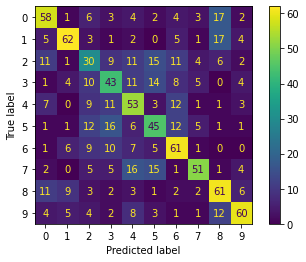

In [ ]:
plot_confusion_matrix(svc, featureMatrixTesting, testingLabels)
plt.show()

# Object Detection: Convolutional Neural Networks
We have presented the proposed implementation for detecting objects with Support Vector Machines. We will now do the same for Convolutional Neural Networks. 
The dataset used for this assignment is made of images, this means that learning local information is more important than global information, since neighbouring pixels have a great correlation between one another. Convolutional layers are the ideal choice for this, as a filter only considers a portion of the image at a time. The fact that we are not using a Fully Connected Neural Network also means that there is less edges between layers. This increases the efficiency of the model overall.



# Preprocessing: Reshaping the Dataset
Unlike SVM, CNN works best with the original images in the dataset, rather than the hog features. The dataset uses the format H x W x C x S, where H is the height of the images, W is the width, C is the channel and S is the number of samples. This poses a problem, since Keras uses the format S x H x W x C. For this reason, we reshape the dataset to fit the proper format.

In [ ]:
print(f'Shape of Training Dataset before reshape: {trainingImages.shape}')
print(f'Shape of Testing Dataset before reshape: {testingImages.shape}')

Shape of Training Dataset before reshape: (10000, 32, 32, 3)
Shape of Testing Dataset before reshape: (1000, 32, 32, 3)


In [ ]:
trainingImages = trainingImages.reshape(10000, 32, 32, 3)
testingImages = testingImages.reshape(1000, 32, 32, 3)

print(f'Shape of Training Dataset after reshape: {trainingImages.shape}')
print(f'Shape of Testing Dataset after reshape: {testingImages.shape}')

Shape of Training Dataset after reshape: (10000, 32, 32, 3)
Shape of Testing Dataset after reshape: (1000, 32, 32, 3)


# Preprocessing: Shuffling the dataset
The labels in the dataset are in order from 0 to 9. This doesn't pose a problem for SVM, but models that use a batch-based stochastic approach, this may cause some issues during training. For this reason, we shuffle the labels and the dataset, making sure not to break the relationship between the images and the labels.

In [ ]:
for i in range(len(trainingLabels)):
    swappingIndex = np.random.randint(0, 10000, 1)
    
    trainingImages[[i, swappingIndex[0]]] = trainingImages[[swappingIndex[0], i]]
    trainingLabels[[i, swappingIndex[0]]] = trainingLabels[[swappingIndex[0], i]]

for i in range(len(testingLabels)):
    swappingIndex = np.random.randint(0, 1000, 1)
    
    testingImages[[i, swappingIndex[0]]] = testingImages[[swappingIndex[0], i]]
    testingLabels[[i, swappingIndex[0]]] = testingLabels[[swappingIndex[0], i]]

# CNN Architecture: Selecting the Layers
This model starts two convolutional layers to capture the local information in the images. The kernel size is set to be (3, 3) because it is shown to be efficient with many other models. the activation function is relu for the same reason. the two convolutional layers are followed by a max pooling layer, capturing the peaks of information and reducing the memory footprint. the data is then flattened, with a Flatten() layer. The model proceeds with a dense layer with a high number of neurons. each neuron has a 20% chance of being reduced to 0 by the droput layer. This should help to prevent the model from overfitting. the model ends with 10 output neurons, each outputing the probability for a given sample to belong to one of the 10 classes available. The final activation function is softmax, since it has proven to behave well in the final layer of other models.

In [ ]:
modelConv = tf.keras.Sequential(layers=[
            tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
            tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(np.unique(trainingLabels)), activation=tf.nn.softmax)])

# CNN Architecture: Compiling

In [ ]:
modelConv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=tf.keras.metrics.SparseCategoricalAccuracy())

# Training: Convolutional Neural Networks

In [ ]:
history = modelConv.fit(trainingImages, trainingLabels, epochs=10, validation_split=0.05, verbose=0)

# Results: Accuracy and Loss Curves

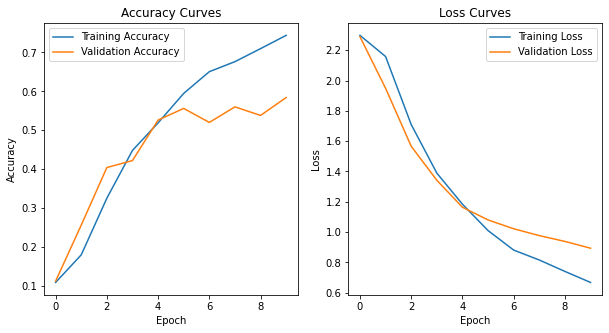

In [ ]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

# Results: Confusion Matrix
Below is the confusion matrix for the cnn.

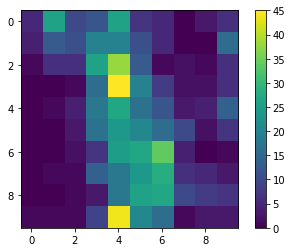

In [ ]:
predictedProbabilities = modelConv.predict(testingImages)

predictedLabels = np.zeros((1000,))

for i in range(1000):
  maxValue = 0
  maxIndex = 0
  for j in range(10):
    if(maxValue < predictedProbabilities[i][j]):
      maxValue = predictedProbabilities[i][j]
      maxIndex = j
  predictedLabels[i] = maxIndex

cm = math.confusion_matrix(testingLabels, predictedLabels, num_classes=10)
plt.imshow(cm, cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()